In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
data = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')

In [3]:
#Only include jobs that have been completed, 'STATE' = COMPLETED
#Exclude jobs with memory usage = 0 Mb
data = (data[
    (data['STATE']=='COMPLETED') & 
    (data['USEDMEM']!='0') &
    (data['USEDMEM']!='0.00M')
    ])

In [4]:
def str2seconds(timestr):
    if len(timestr) == 8:
        # split in hh, mm, ss
        hh, mm, ss = timestr.split(':')
        return int(hh) * 3600 + int(mm) * 60 + int(ss)
    else:
        d = timestr[0]
        dropday = timestr[2:]
        hh, mm, ss = dropday.split(':')
        return int(d) *3600*24 + int(hh) * 3600 + int(mm) * 60 + int(ss)

In [5]:
#First take times and convert to seconds
usedtime = data['USEDTIME']
reqtime = data['REQTIME']
usedtime_seconds = []
reqtime_seconds = []

for string in usedtime:
    usedtime_seconds.append(str2seconds(string))

for string in reqtime:
    reqtime_seconds.append(str2seconds(string))

In [6]:
data['USEDMEM'] = data['USEDMEM'].str.strip('M').astype(float)

In [7]:
data['req_time_seconds'] = reqtime_seconds
data['used_time_seconds'] = usedtime_seconds

#Get used memory per GPU for each job 
data['USEDMEM_per_GPU'] = data['USEDMEM']/data['GPUS']
#Weight the used memory based on amount of time the request was 
data['weighted_used_mem'] = (data['USEDMEM_per_GPU']*data['used_time_seconds'])/sum(usedtime_seconds)

In [8]:
#Group by partition name for seperate analysis if needed
turing = data[data['PARTITION'] == 'turing']
maxwell = data[data['PARTITION'] == 'maxwell']
pascal = data[data['PARTITION'] == 'pascal']

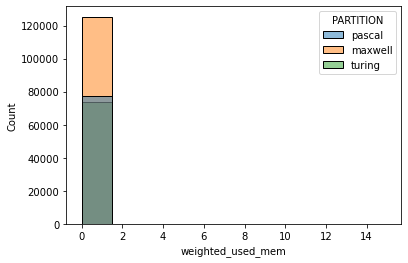

In [9]:
sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
plt.show()

# Skewed Data 
This dataset is extremely skewed so lets set the axes to log scale. 

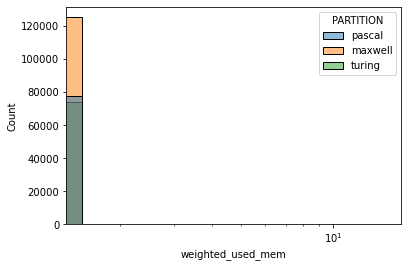

In [10]:
histogram = sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
histogram.set(xscale='log')
plt.show()

We can see that that the histogram is still the same so lets look at the box plot and CDF represenatations of the data to get a closer picture of each of the partitions. 

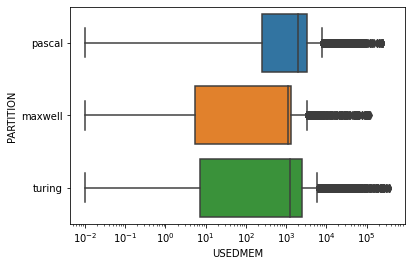

In [11]:
boxplot = sns.boxplot(x = data['USEDMEM'], y = data['PARTITION'])
boxplot.set(xscale= 'log')
plt.show()

In [12]:
data['weighted_used_mem'].groupby(data['PARTITION']).describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,125370.0,0.002595,0.068776,0.0,3.721905e-08,0.000131,0.000186,6.152163
pascal,77769.0,0.018569,0.205759,0.0,1.008850e-04,0.000460,0.001988,14.197097
turing,74336.0,0.043253,0.412154,0.0,6.504556e-08,0.000263,0.000803,14.952076


We can see that each of the partitions have very simliar medians for amount of data used per GPU.   

In [13]:
#Lets look at the number of outliers for each of the partition distributions
df_quant = data.pivot(values=['weighted_used_mem'], columns=['PARTITION'])
Q1 = df_quant.quantile(0.25)
Q3 = df_quant.quantile(0.75)
IQR = Q3 - Q1

In [14]:
#Calculate the percentage of number of outliers to the total number of jobs in that distribution
outliers = ((df_quant < (Q1 - 1.5 * IQR)) | (df_quant > (Q3 + 1.5 * IQR))).sum()
print('The number of outliers for each of the partitions:\n', outliers)
percentage_outliers = outliers/[len(maxwell), len(pascal), len(turing)]
print('The percentage of outliers to total number of jobs per partition:\n', percentage_outliers)


The number of outliers for each of the partitions:
                    PARTITION
weighted_used_mem  maxwell      10946
                   pascal       17430
                   turing       14888
dtype: int64
The percentage of outliers to total number of jobs per partition:
                    PARTITION
weighted_used_mem  maxwell      0.087310
                   pascal       0.224125
                   turing       0.200280
dtype: float64


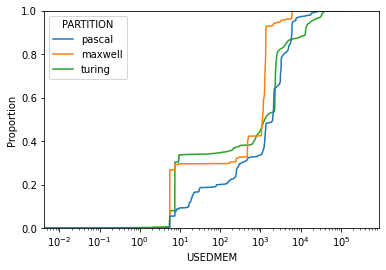

In [15]:
cdf_plot = sns.ecdfplot(x = data['USEDMEM'], hue = data['PARTITION'])
cdf_plot.set(xscale= 'log')
plt.show()

# Question 2 

In [16]:
data['weighted_num_GPUs'] = (data['GPUS']*data['used_time_seconds'])/sum(usedtime_seconds)

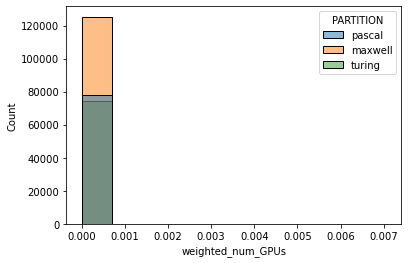

In [17]:
histogram_2 = sns.histplot(x = data['weighted_num_GPUs'], hue = data['PARTITION'], bins = 10)

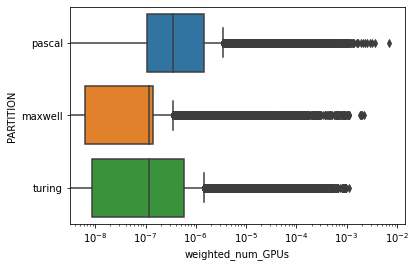

In [18]:
boxplot_2 = sns.boxplot(x = data['weighted_num_GPUs'], y = data['PARTITION'])
boxplot_2.set(xscale= 'log')
plt.show()

Proportion of jobs that used greater than 4 GPUS, aka an RoCE machine 

In [19]:
df_RoCE = data[data['GPUS']>4]

Proprtion for all jobs that have greater than 4 GPUs

In [20]:
prop_RoCE = len(df_RoCE)/len(data)
prop_RoCE

0.0031894765294170646

This is the breakdown of proportions of jobs that use the RoCE networking for each partition

In [21]:
df_RoCE.pivot(values = 'GPUS', columns= 'PARTITION').notna().sum()/[len(maxwell), len(pascal), len(turing)]

PARTITION
maxwell    0.002122
pascal     0.005696
turing     0.002368
dtype: float64

# Question 3 

In [22]:
data['gpu_runtime_total_seconds'] = data['GPUS']*data['used_time_seconds']

Try to get the proportion of GPU runtime to total possible GPU runtime

In [23]:
possible_run_times_sec = [(maxwell['GPUS']*maxwell['req_time_seconds']).sum(), (pascal['GPUS']*pascal['req_time_seconds']).sum(), (turing['GPUS']*turing['req_time_seconds']).sum()]
myInt = 365*24*60*60 #Change to seconds to years 
newList = [x / myInt for x in possible_run_times_sec]

In [24]:
print('The proportion for total runtime per GPU to the requested runtime per GPU for each of the partitions:\n')
(data.groupby('PARTITION')['gpu_runtime_total_seconds'].sum()/(365*24*60*60))/(newList)

The proportion for total runtime per GPU to the requested runtime per GPU for each of the partitions:



PARTITION
maxwell    0.042236
pascal     0.076216
turing     0.165716
Name: gpu_runtime_total_seconds, dtype: float64

# Question 4 

First filter the data with only regular jobs to get rid of array request which could throw off the actual top users

In [25]:
from numpy import NaN

non_array_jobs = []
for index, row in data.iterrows():
    if len(row["JOBID"]) == 8:
        non_array_jobs.append(index)
    else:
        non_array_jobs.append(NaN)


In [26]:
data_non_array_jobs = data[data.index == non_array_jobs]

In [38]:
users_info = data_non_array_jobs.pivot(index = ['ACCOUNT','USER', 'JOBID'], columns = 'EXITCODE')
users_info

USEDMEM     REQTIME    USEDTIME NODES CPUS GPUS  \
EXITCODE                       0:0         0:0         0:0   0:0  0:0  0:0   
ACCOUNT USER     JOBID                                                       
almonds annetta  39342056   166.81  1-00:00:00    00:05:26     1    5    1   
                 39343810     5.41  2-00:00:00    00:00:16     1    5    1   
                 39343811     5.41  2-00:00:00    00:00:09     1    5    1   
                 39343851   161.09  2-00:00:00    00:03:28     1    5    1   
                 39344173   185.50  2-00:00:00    01:49:13     1    5    1   
...                            ...         ...         ...   ...  ...  ...   
white   brittani 41867882   993.08  5-00:00:00  5-00:00:21     1   12    4   
                 42093993  1117.69  5-00:00:00  2-03:45:40     1   12    4   
                 42134332  4843.26    06:00:00    05:06:19     1    9    3   
                 42143179   909.12    12:00:00    12:00:08     1    9    3   
                 45012538   913.52    01:00:00    00:36:42     1    3    1   

                          PARTITION      STATE req_time_seconds  \
EXITCODE                        0:0        0:0              0:0   
ACCOUNT USER     JOBID                                            
almonds annetta  39342056    turing  COMPLETED            86400   
                 39343810    turing  COMPLETED           172800   
                 39343811    turing  COMPLETED           172800   
                 39343851    turing  COMPLETED           172800   
                 39344173    turing  COMPLETED           172800   
...                             ...        ...              ...   
white   brittani 41867882   maxwell  COMPLETED           432000   
                 42093993   maxwell  COMPLETED           432000   
                 42134332   maxwell  COMPLETED            21600   
                 42143179   maxwell  COMPLETED            43200   
                 45012538   maxwell  COMPLETED             3600   

                          used_time_seconds USEDMEM_per_GPU weighted_used_mem  \
EXITCODE                                0:0             0:0               0:0   
ACCOUNT USER     JOBID                                                          
almonds annetta  39342056               326        166.8100      3.409660e-05   
                 39343810                16          5.4100      5.427360e-08   
                 39343811                 9          5.4100      3.052890e-08   
                 39343851               208        161.0900      2.100890e-05   
                 39344173              6553        185.5000      7.621764e-04   
...                                     ...             ...               ...   
white   brittani 41867882            432021        248.2700      6.725127e-02   
                 42093993            186340        279.4225      3.264667e-02   
                 42134332             18379       1614.4200      1.860415e-02   
                 42143179             43208        303.0400      8.209856e-03   
                 45012538              2202        913.5200      1.261266e-03   

                          weighted_num_GPUs gpu_runtime_total_seconds  
EXITCODE                                0:0                       0:0  
ACCOUNT USER     JOBID                                                 
almonds annetta  39342056      2.044038e-07                       326  
                 39343810      1.003209e-08                        16  
                 39343811      5.643050e-09                         9  
                 39343851      1.304172e-07                       208  
                 39344173      4.108767e-06                      6553  
...                                     ...                       ...  
white   brittani 41867882      1.083518e-03                   1728084  
                 42093993      4.673449e-04                    745360  
                 42134332      3.457121e-05                     5513

Look into the array jobs with underscore in the job ID column

In [40]:
top_5_num_jobs = users_info.groupby(level=[0,1]).size().nlargest(5)
top_5_num_jobs

ACCOUNT     USER   
malanga     arline     8110
glasshouse  erick      7266
            treva      6271
            collins    4279
            jolette    1621
dtype: int64

In [64]:
top_5_users = users_info.sort_index().loc[top_5_num_jobs.index.sort_values()[0]:top_5_num_jobs.index.sort_values()[-1]]